In [1]:
import pandas as pd
import numpy as np
import os
import sys
import fcLib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import 2022 weather data from pvlib
# Import GridWorks load data millinocket_me_2020

In [3]:
# Import yearly load and outside temperature data from GridWorks
df = pd.read_excel(os.getcwd()+'/data/gridworks_yearly_data.xlsx', header=3, index_col = 0)
df.index = pd.to_datetime(df.index)
df.index.name = None

# Rename columns
renamed_columns = {
    'Outside Temp F': 'T_OA',
    'House Power Required AvgKw': 'Q_load'}
df.rename(columns=renamed_columns, inplace=True)

# Convert outside air temperature from °F to °C
df['T_OA'] = df['T_OA'].apply(lambda x: round(5/9 * (x-32),2))

# Keep only date, weather, and load
df = df[['T_OA','Q_load']]

df.head()

,T_OA,Q_load
2022-01-01 00:00:00,-3.89,5.91
2022-01-01 01:00:00,-3.33,5.77
2022-01-01 02:00:00,-2.78,5.67
2022-01-01 03:00:00,-3.33,5.77
2022-01-01 04:00:00,-3.33,5.71


In [4]:
from scipy import stats
correlation, p_value = stats.spearmanr(df.T_OA, df.Q_load)
print(f"Correlation between outside temperature and load: {round(correlation,2)}, p-value: {p_value}")

Correlation between outside temperature and load: -0.99, p-value: 0.0


In [5]:
# Split the data into X (weather) and y (load)
X_columns = [col for col in df.columns if not 'Q_load' in col]
y_columns = [col for col in df.columns if 'Q_load' in col]
X = df[X_columns]
y = df[y_columns]

# Create training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42)

print("X columns: ", X_columns)
print("y columns: ", y_columns)

X columns:  ['T_OA']
y columns:  ['Q_load']


In [6]:
# Create a dataframe to store the RMSE of each forecaster on the testing data
library = fcLib.forecasters(fcLib.forecaster_list)
forecaster_names = [forecaster['name'] for forecaster in library.forecasters]
forecaster_names.remove('todt')
forecaster_names.remove('sarimax_with_forecast')
scores = pd.DataFrame(index = forecaster_names, columns = ['RMSE'])

# Create a dict to store prediction values for a 48-hour plot
data_plots = {}

# Iterate through each of the models
for forecaster in library.forecasters:

    #print(forecaster['name'])
    if forecaster['name'] == 'todt': continue
    if forecaster['name'] == 'sarimax_with_forecast': continue
    data_plots[f"{forecaster['name']}"] = []

    # Fit the model to the training data and predict for the testing data
    model = getattr(fcLib, forecaster['fun'])(**forecaster['parameter'])
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    # Calculate the rmse and store it in the associated dataframe
    rmse = np.sqrt(mean_squared_error(y_test, predict))
    scores.loc[forecaster['name'], 'RMSE'] = rmse

    # For 48-hour plot
    for i in range(48):    
        forecast = [[X.T_OA[i].tolist()]]
        predict = model.predict(forecast)

        if forecaster['name'] == 'gradient_boosting': 
            data_plots[f"{forecaster['name']}"].append(predict[0])
        else:
            data_plots[f"{forecaster['name']}"].append(predict)

display(scores)

,RMSE
extra_trees_pipeline,0.208017
random_forest_pipeline,0.190428
multi_layer_perceptron,0.198056
tuned_mlp,0.197874
tuned_Total_mlp,0.193383
tuned_Fast_mlp,0.194546
random_forest,0.189912
extra_trees,0.189836
gradient_boosting,0.189886


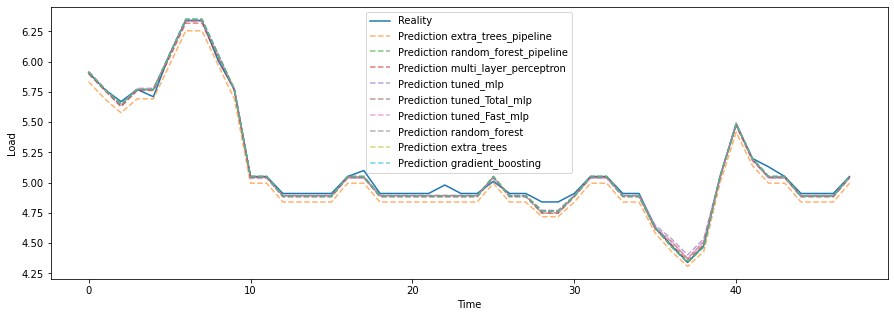

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df.Q_load[0:48].tolist(), label="Reality")
for forecaster in library.forecasters:
    if forecaster['name'] == 'todt': continue
    if forecaster['name'] == 'sarimax_with_forecast': continue
    plt.plot(data_plots[f"{forecaster['name']}"], label=f"Prediction {forecaster['name']}", alpha=0.6, linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.show()